In [ ]:

# Install AutoKeras
!pip3 install autokeras

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters 
import numpy as np
import autokeras as ak

### Getting and preprocessing the Reuters newswire dataset 

In [ ]:
# Download and prepare the dataset
def reuters_raw(max_features=20000):
    index_offset = 3  # word index offset

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(
        num_words=max_features,
        index_from=index_offset)
    x_train = x_train
    y_train = y_train.reshape(-1, 1)
    x_test = x_test
    y_test = y_test.reshape(-1, 1)

    word_to_id = tf.keras.datasets.reuters.get_word_index()
    word_to_id = {k: (v + index_offset) for k, v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2

    id_to_word = {value: key for key, value in word_to_id.items()}
    x_train = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_train))
    x_test = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_test))
    x_train = np.array(x_train, dtype=np.str)
    x_test = np.array(x_test, dtype=np.str)
    return (x_train, y_train), (x_test, y_test)

#### Creating the data sets

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters_raw()
print(x_train.shape)  # (8982,)
print(y_train.shape)  # (8982, 1)

557056/550378 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


(8982,)
(8982, 1)


### Showing some samples

In [ ]:
print(x_train[0][:50])  # <START> <UNK> <UNK> said as a result of its decemb

<START> <UNK> <UNK> said as a result of its decemb


####Render a Word Cloud
A Word Cloud (also known as a tag cloud) is a text-based data visualization technique, in which words are displayed in different sizes based on how often they appear in the text

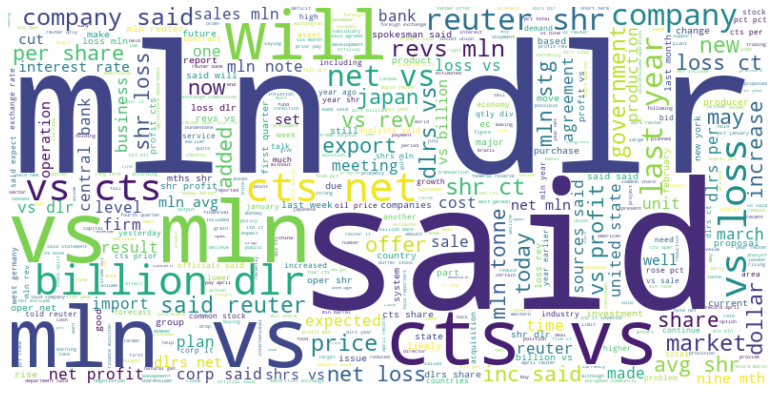

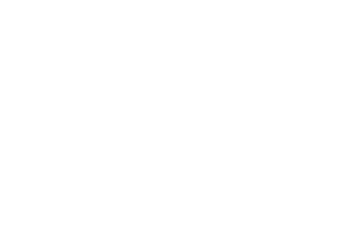

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(x_train) # join all reviews in training set
wordcount = 20000
stopwords = set(STOPWORDS)
stopwords.update(['UNK', 'PAD', 'START'])
wc = WordCloud(width=800, height=400, background_color="white", max_words=wordcount, stopwords=stopwords)
wc.generate(text)

plt.figure( figsize=(14,7) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

### Creating and training the models

In [ ]:
# Initialize the TextClassifier
clf = ak.TextClassifier(
    max_trials=2,
    overwrite=True,
)

# Callback to avoid overfitting with the EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=2),
]

# Search for the best model.
clf.fit(
    x_train,
    y_train,
    callbacks=cbs
)

Trial 2 Complete [00h 00m 41s]
val_loss: 1.1574714183807373

Best val_loss So Far: 0.9651017189025879
Total elapsed time: 00h 01m 20s
INFO:tensorflow:Oracle triggered exit
Epoch 1/6
281/281 [==============================] - 5s 16ms/step - loss: 2.4081 - accuracy: 0.4190
Epoch 2/6
281/281 [==============================] - 4s 15ms/step - loss: 1.4365 - accuracy: 0.6616
Epoch 3/6
281/281 [==============================] - 4s 15ms/step - loss: 1.1436 - accuracy: 0.7245
Epoch 4/6
281/281 [==============================] - 4s 15ms/step - loss: 0.9179 - accuracy: 0.7780
Epoch 5/6
281/281 [==============================] - 4s 15ms/step - loss: 0.7517 - accuracy: 0.8181
Epoch 6/6
281/281 [==============================] - 4s 15ms/step - loss: 0.6245 - accuracy: 0.8425
INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


### Evaluating the best model

In [ ]:
# Evaluate the chosen model with testing data
clf.evaluate(x_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 0.9743 - accuracy: 0.7778


[0.9742580652236938, 0.777827262878418]

###Visualizing the model

In [ ]:
# First we export the model to a keras model
keras_model = clf.export_model()

# Now, we ask for the model Sumary:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 1)                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 512)               0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 64)           320064    
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 256)          82176     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0     

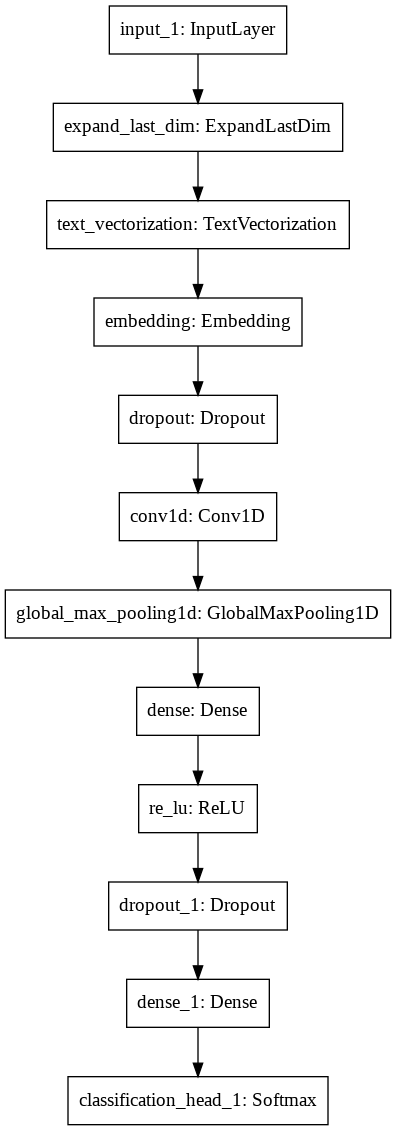

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(keras_model)

###Customizing the model

In [ ]:
input_node = ak.TextInput()
output_node = ak.TextBlock(block_type="ngram")(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)
clf.fit(x_train, y_train, epochs=100)

Trial 1 Complete [00h 00m 33s]
val_loss: 1.0364753007888794

Best val_loss So Far: 1.0364753007888794
Total elapsed time: 00h 00m 33s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
281/281 [==============================] - 3s 8ms/step - loss: 2.2548 - accuracy: 0.5225
Epoch 2/100
281/281 [==============================] - 2s 8ms/step - loss: 0.8145 - accuracy: 0.8318
Epoch 3/100
281/281 [==============================] - 2s 8ms/step - loss: 0.4595 - accuracy: 0.8978
Epoch 4/100
281/281 [==============================] - 2s 8ms/step - loss: 0.3188 - accuracy: 0.9285
Epoch 5/100
281/281 [==============================] - 2s 8ms/step - loss: 0.2597 - accuracy: 0.9391
Epoch 6/100
281/281 [==============================] - 2s 8ms/step - loss: 0.2238 - accuracy: 0.9450
Epoch 7/100
281/281 [==============================] - 2s 8ms/step - loss: 0.2034 - accuracy: 0.9443
Epoch 8/100
281/281 [==============================] - 2s 8ms/step - loss: 0.1850 - accuracy: 0.9465
Epoch 9/100
281/281 